In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

from abc import abstractmethod, ABC
from typing import Sequence, Optional, Literal, Callable

from numpy.typing import NDArray

np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Handy utility functions

In [2]:
# def append_ones(matrix, axis=1):
#     return np.concatenate((matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=axis)


def zeros(*dims: int) -> NDArray:
    return np.zeros(shape=tuple(dims), dtype=np.float32)


def ones(*dims: int) -> NDArray:
    return np.ones(shape=tuple(dims), dtype=np.float32)


def rand(*dims: int) -> NDArray:
    return np.random.rand(*dims).astype(np.float32)


def randn(*dims: int) -> NDArray:
    return np.random.randn(*dims).astype(np.float32)


def chunks(seq: NDArray, size: int):
    return (seq[pos : pos + size] for pos in range(0, len(seq), size))


def as_matrix(vector: NDArray) -> NDArray:
    return np.reshape(vector, (-1, 1))


def one_hot_encode(labels: NDArray) -> NDArray:
    one_hot = zeros(labels.shape[0], np.max(labels) + 1)
    one_hot[np.arange(labels.shape[0]), labels] = 1
    return one_hot.astype(np.float32)


def tiles(examples: NDArray):
    space = 2
    rows, cols, h, w = examples.shape

    img_matrix = np.empty(shape=(rows * (h + space) - space, cols * (h + space) - space))
    img_matrix.fill(np.nan)

    for r in range(rows):
        for c in range(cols):
            x_0 = r * (h + space)
            y_0 = c * (w + space)
            ex_min = np.min(examples[r, c])
            ex_max = np.max(examples[r, c])
            img_matrix[x_0 : x_0 + h, y_0 : y_0 + w] = (examples[r, c] - ex_min) / (ex_max - ex_min)

    plt.matshow(img_matrix, cmap="gray", interpolation="none")
    plt.axis("off")
    plt.show()

### Activation functions

In [3]:
def sigmoid(x: NDArray, sample: bool = False) -> NDArray:
    σ = 1.0 / (1.0 + np.exp(-x))
    if sample:
        return σ > rand(*σ.shape)
    return σ


def gaussian(x: NDArray, sample: bool) -> NDArray:
    if sample:
        return x + randn(*x.shape)
    return x

# MNIST dataset

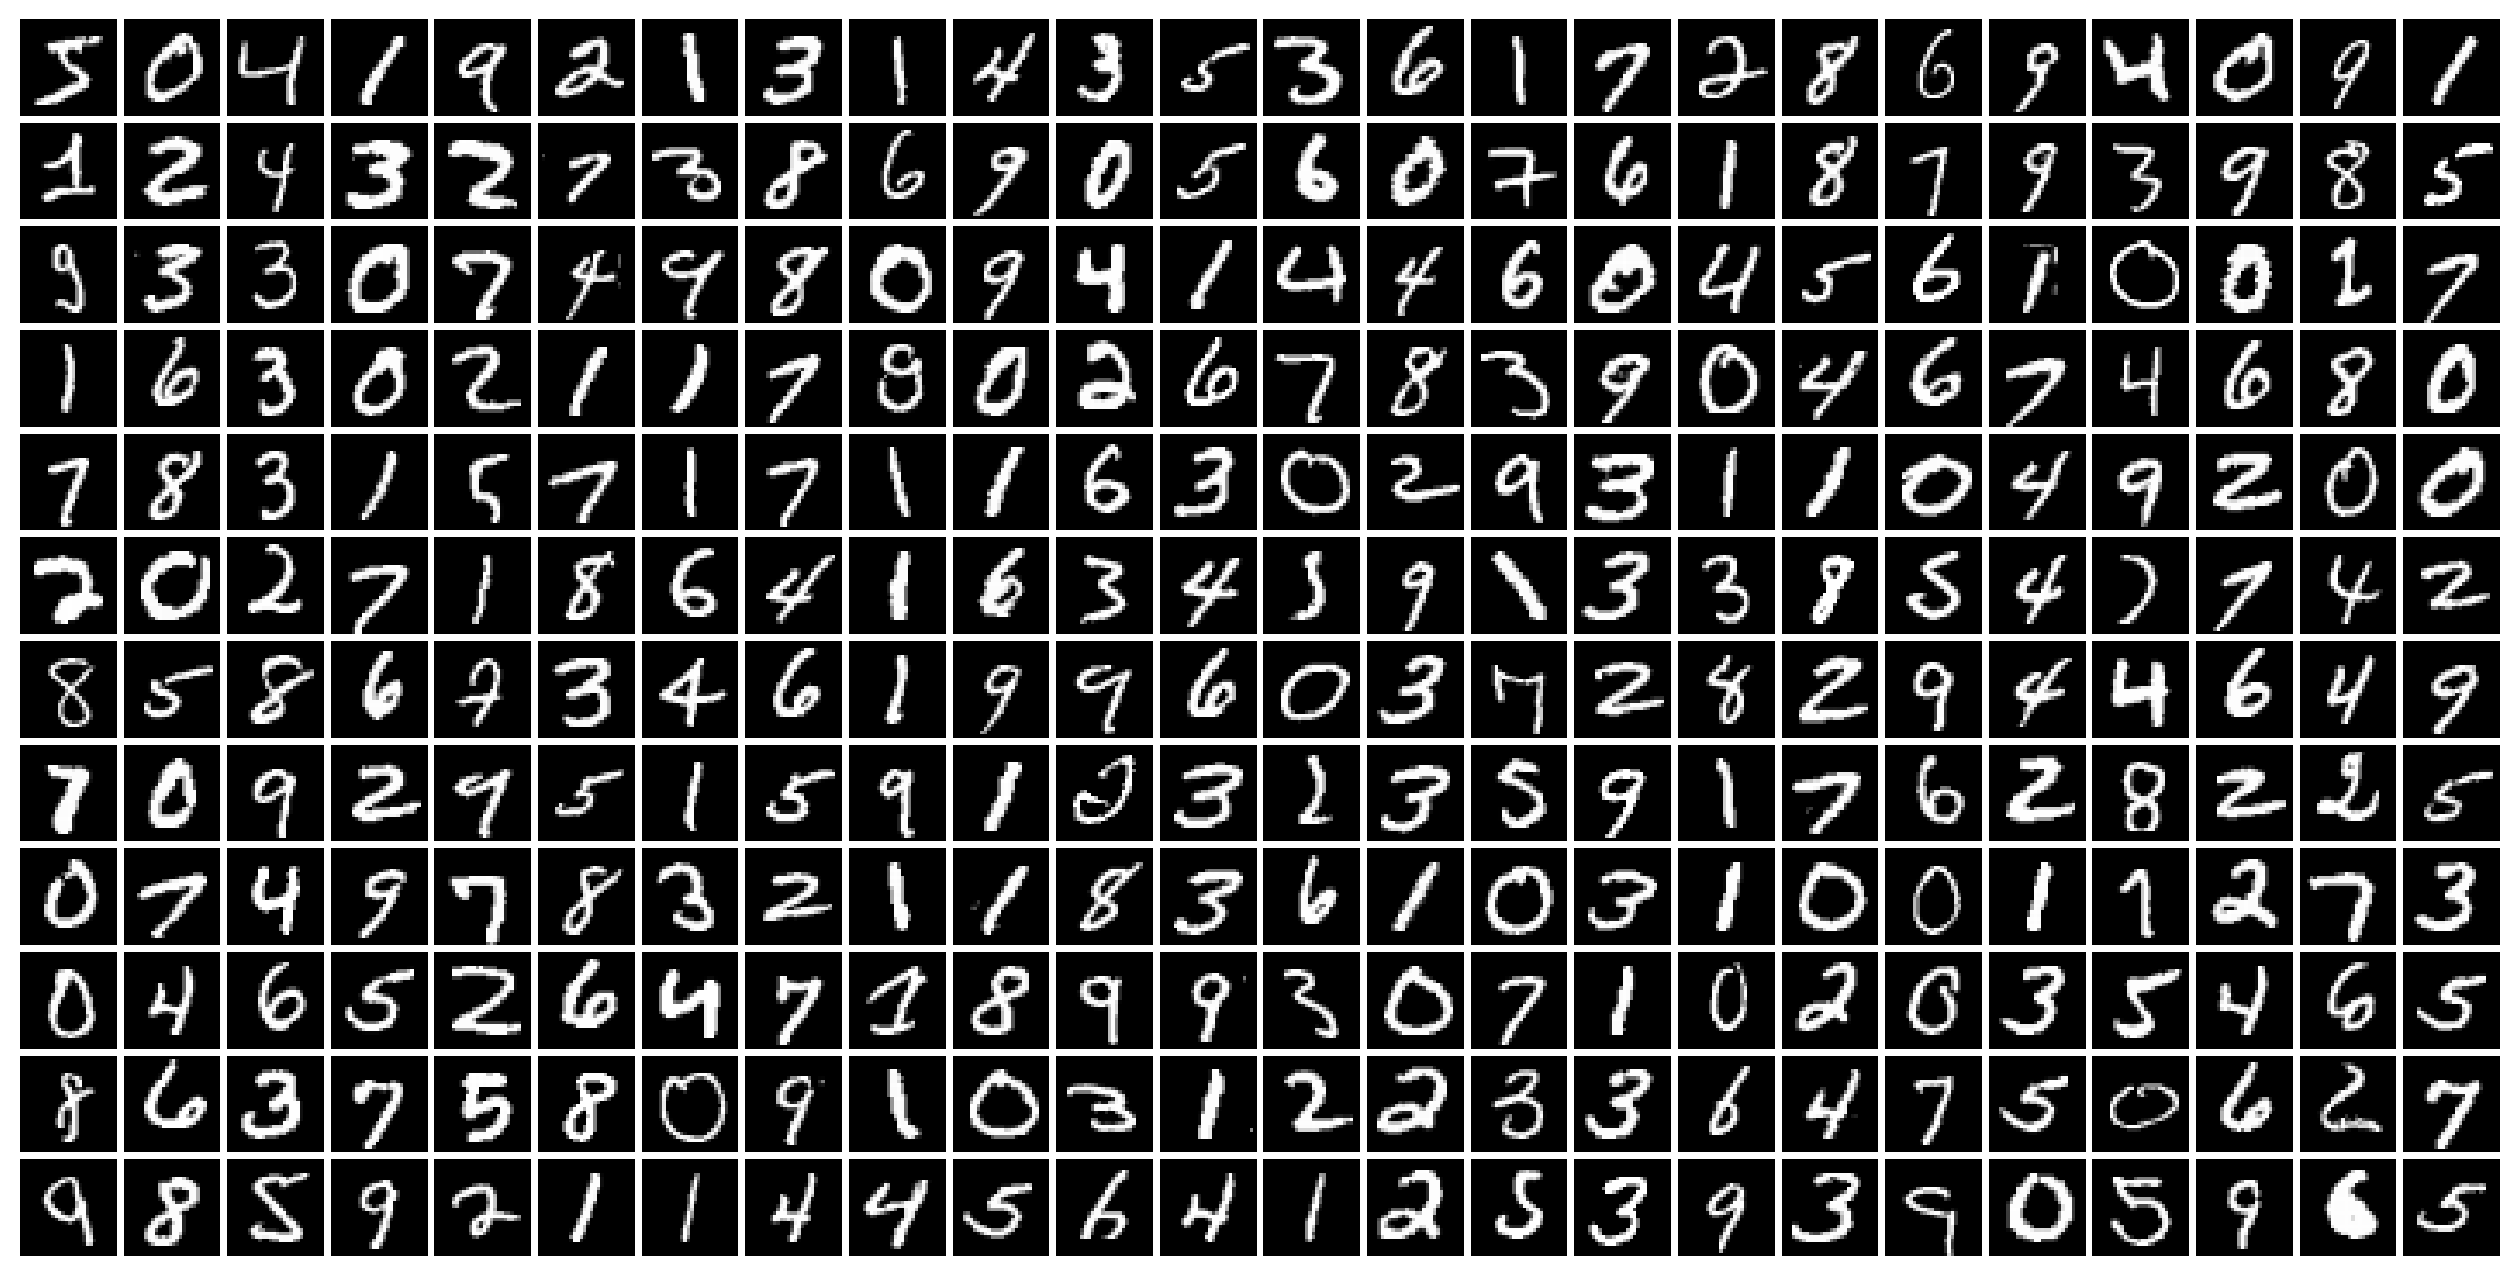

In [4]:
from mnists import MNIST

mnist = MNIST()
digits = mnist.train_images()
digits = digits[: 12 * 24]
digits = digits.reshape(-1, 24, 28, 28)
tiles(digits)

# RBM & DBN training

In [5]:
class RBM:
    def __init__(
        self,
        vsize: int,
        hsize: int,
        v_activation: Callable[[NDArray, bool], NDArray],
        h_activation: Callable[[NDArray, bool], NDArray],
        lr: float,
        momentum: float,
        l2_penalty: float,
        init_method: Literal["Xavier", "He"],
    ):
        self.vsize = vsize
        self.hsize = hsize
        self.v_activation = v_activation
        self.h_activation = h_activation

        # Training hyper-params
        self.lr = lr
        self.momentum = momentum
        self.l2_penalty = l2_penalty

        # Initialize
        self.init_method = init_method
        self.reset()

    def reset(self):
        # Weights initialization
        match self.init_method:
            case "Xavier":
                scale = np.sqrt(6 / (self.vsize + self.hsize))
                self.w = np.random.uniform(-scale, +scale, size=(self.vsize, self.hsize)).astype(np.float32)
            case "He":
                scale = np.sqrt(4 / (self.vsize + self.hsize))
                self.w = np.random.normal(0, scale, size=(self.vsize, self.hsize)).astype(np.float32)
            case _:
                raise ValueError(f"Unrecognised `init_method`: {self.init_method}")

        # Bias initialization
        self.b = zeros(self.vsize)
        self.c = zeros(self.hsize)

        # Velocity (momentum) tensor initialization
        self.m_w = zeros(self.vsize, self.hsize)
        self.m_b = zeros(self.vsize)
        self.m_c = zeros(self.hsize)

    def probas_v(self, h: NDArray, sample: bool) -> NDArray:
        return self.v_activation(self.b + h @ self.w.T, sample=sample)

    def probas_h(self, v: NDArray, sample: bool) -> NDArray:
        return self.h_activation(self.c + v @ self.w, sample=sample)

    def sample(self, v: NDArray, steps: int) -> NDArray:
        # --- Gibbs sampling
        for k in range(steps):
            h = self.probas_h(v, sample=True)
            v = self.probas_v(h, sample=(k < steps - 1))
        return v

In [6]:
def reconstuction_error(rbm: RBM, v: NDArray) -> float:
    batch_size = v.shape[0]
    σ = rbm.sample(v, steps=1)
    return 1 / batch_size * np.sum((v - σ) ** 2)


def draw_rbm_filters(rbm: RBM):
    filters = rbm.w.T
    filters = filters.reshape(8, -1, 28, 28)
    tiles(filters)

In [7]:
def cdk(rbm: RBM, minibatch: NDArray, k: int = 1):
    batch_size = minibatch.shape[0]
    v = minibatch

    # Compute gradients
    # -----------------

    # Positive phase
    σ = rbm.probas_h(v, sample=False)

    grad_w = -1 / batch_size * (v.T @ σ)
    grad_b = -1 / batch_size * (v.sum(axis=0))
    grad_c = -1 / batch_size * (σ.sum(axis=0))

    # Negative phase

    # --- Gibbs sampling
    h = rbm.probas_h(v, sample=True)
    v = rbm.probas_v(h, sample=True)
    for _ in range(k - 1):
        h = rbm.probas_h(v, sample=True)
        v = rbm.probas_v(h, sample=True)

    # --- Negative gradient estimation
    σ = rbm.probas_h(v, sample=False)

    grad_w += 1 / batch_size * (v.T @ σ)
    grad_b += 1 / batch_size * (v.sum(axis=0))
    grad_c += 1 / batch_size * (σ.sum(axis=0))

    # Apply L2 regularization
    # -----------------------
    grad_w += rbm.l2_penalty * rbm.w

    # Update params
    # -------------
    rbm.m_w = rbm.momentum * rbm.m_w - rbm.lr * grad_w
    rbm.m_b = rbm.momentum * rbm.m_b - rbm.lr * grad_b
    rbm.m_c = rbm.momentum * rbm.m_c - rbm.lr * grad_c

    rbm.w += rbm.m_w
    rbm.b += rbm.m_b
    rbm.c += rbm.m_c

In [8]:
def propagate_up(dbn: Sequence[RBM], n_layers: int, v: NDArray) -> NDArray:
    assert 0 <= n_layers < len(dbn)
    for i in range(n_layers):
        v = dbn[i].probas_h(v, sample=False)
    return v


def propagate_dn(dbn: Sequence[RBM], n_layers: int, h: NDArray) -> NDArray:
    assert 0 <= n_layers < len(dbn)
    for i in reversed(range(n_layers)):
        h = dbn[i].probas_v(h, sample=False)
    return h


def dbn_reconstuction_error(dbn: Sequence[RBM], n_layers: int, minibatch: NDArray) -> float:
    assert 0 <= n_layers < len(dbn)
    visible = propagate_up(dbn, n_layers, minibatch)
    return reconstuction_error(dbn[n_layers], visible)


def train_dbn_layer(dbn: Sequence[RBM], layer_idx: int, dataset: NDArray, batch_size: int):
    dataset = propagate_up(dbn, layer_idx, dataset)
    batches_limit = dataset.shape[0] / batch_size
    for batch_idx, batch in enumerate(chunks(dataset, batch_size)):
        cdk(dbn[layer_idx], batch)
        if batch_idx % round(batches_limit / 40) == 0:
            print("#", end="")


def train_dbn(
    dbn: Sequence[RBM],
    dataset: NDArray,
    monitoring_set: NDArray,
    batch_size: int,
    epochs_count: int,
):
    for layer_idx in range(len(dbn)):
        print("\nLearning layer {}".format(layer_idx))

        for epoch in range(epochs_count):
            print("Epoch {}:".format(epoch + 1), end="\t")

            if epoch == 5:
                dbn[layer_idx].momentum = 0.9

            start_time = time.time()
            train_dbn_layer(dbn, layer_idx, dataset, batch_size)
            elapsed = time.time() - start_time

            error = dbn_reconstuction_error(dbn, layer_idx, monitoring_set)
            print("\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(elapsed, error))

# Part 1. Autoencoder training with Nesterov accelerated gradient descend

In [9]:
class Layer(ABC):
    # Outputs of the layer after forward pass
    y: Optional[NDArray]

    @abstractmethod
    def reset(self, *args, **kwargs):
        """Initialize the layer."""
        raise NotImplementedError

    @abstractmethod
    def forward(self, x: NDArray, training: bool) -> NDArray:
        """Propagate the input `x` forward through the layer and save the output in `self.y`."""
        raise NotImplementedError

    @abstractmethod
    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        """
        Given layer input `x` and ∂Loss/∂y (`grad_y`)
            * compute ∂Loss/∂x and ∂Loss/∂θ (where θ are the layer's params;
            * update parameters using (momentum) SGD;
            * return ∂Loss/∂x;

        NOTE: We assume that the layers are connected in a simple path (i.e. the computation graph
        is linear) and thus we don't have to keep and accumulate the gradients ∂Loss/∂y in the layer
        itself, but can instead just dynamically pass ∂Loss/∂y while traversing this linear
        computation graph.
        """
        raise NotImplementedError

In [10]:
class Sigmoid(Layer):
    def __init__(self):
        self.reset()

    def reset(self):
        self.y: Optional[NDArray] = None

    def forward(self, x: NDArray, training: bool) -> NDArray:
        self.y = 1.0 / (1.0 + np.exp(-x))
        return self.y

    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        # --- Compute ∂Loss/∂x
        grad_x = grad_y * (self.y * (1.0 - self.y))
        # --- Propagate ∂Loss/∂x backward
        return grad_x

In [11]:
class Linear(Layer):
    def __init__(
        self,
        vsize: int,
        hsize: int,
        lr: float,
        momentum: float,
        l2_penalty: float,
        init_method: Literal["Xavier", "He"],
    ):
        self.vsize: int = vsize
        self.hsize: int = hsize
        self.lr: float = lr
        self.momentum: float = momentum
        self.l2_penalty: float = l2_penalty
        self.init_method = init_method
        self.reset()

    def reset(self):
        # Weights initialization
        match self.init_method:
            case "Xavier":
                scale = np.sqrt(6 / (self.vsize + self.hsize))
                self.w = np.random.uniform(-scale, +scale, size=(self.vsize, self.hsize)).astype(np.float32)
            case "He":
                scale = np.sqrt(4 / (self.vsize + self.hsize))
                self.w = np.random.normal(0, scale, size=(self.vsize, self.hsize)).astype(np.float32)
            case _:
                raise ValueError(f"Unrecognised `init_method`: {self.init_method}")

        # Biases initialization
        self.b = zeros(self.hsize)

        # Velocity (momentum) tensors initialization
        self.m_w = zeros(self.vsize, self.hsize)
        self.m_b = zeros(self.hsize)

        # Outputs
        self.y: Optional[NDArray] = None

    def forward(self, x: NDArray, training: bool) -> NDArray:
        if not training:
            self.y = (self.b - self.momentum * self.m_b) + x @ (self.w - self.momentum * self.m_w)
        else:
            self.y = self.b + x @ self.w
        return self.y

    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        # --- Compute ∂Loss/∂x
        grad_x = grad_y @ self.w.T

        # --- Compute  ∂Loss/∂w and ∂Loss/∂b
        grad_w = x.T @ grad_y
        grad_b = grad_y.sum(axis=0)

        # --- Apply L2 regularization
        grad_w += self.l2_penalty * self.w

        # --- Update params
        # NOTE: We use the Bengio's equations for Nesterov momentum update as they require minimal
        # changes to the code (see: Sec.3.5. of https://arxiv.org/pdf/1212.0901). One downside of
        # using these update equations is that the parameters `w`, `b` are not really the ones from
        # the original Nesterov formulation but are shifted by `self.momentum * self.m_w` or
        # `self.momentum * self.m_b` respectively. This is not really a problem since after enough
        # epochs the velocities are almost 0 and the values of parameters coincide but for the sake
        # of being fully correct we shift back the weights in the `forward()` method when not
        # training.
        self.w += self.momentum**2 * self.m_w - self.lr * (1 + self.momentum) * grad_w
        self.b += self.momentum**2 * self.m_b - self.lr * (1 + self.momentum) * grad_b

        self.m_w = self.momentum * self.m_w - self.lr * grad_w
        self.m_b = self.momentum * self.m_b - self.lr * grad_b

        # --- Propagate ∂Loss/∂x backward
        return grad_x

In [12]:
def draw_layer_filters(layer: Linear):
    filters = layer.w.T
    filters = filters.reshape(8, -1, 28, 28)
    tiles(filters)

## Error backpropagation with Nesterov accelerated gradient descend

__Forward pass.__ When ```compute_derivatives == false```, we are not training the network but use it to make predictions. In this case we cannot use weights in ```layer.W``` directly: in Nesterov method weights in this matrix are shifted along the direction of momentum (that is, they are at the point in the weight space where the gradient is calculated). We need to account for this when calculating the total input to the next layer.

In [13]:
def forward_pass(model: Sequence[Layer], x: NDArray, training: bool) -> NDArray:
    for layer in model:
        x = layer.forward(x, training=training)
    return x

__Backward pass.__ Implement Nesterov updates in the backward pass of error backpropagation.

Remember that the weights in ```layer.W``` are shifted along the direction of momentum. Before we change the momentum matrix (but after we have everything needed to calculate the gradient), we must fix (i.e. _un-shift_) these weights.

At the end of the backward pass, we must update the weight matrix accoring to the momentum interpretation of the Nesterov method.

In [14]:
def error_backpropagate(model: Sequence[Layer], batch: NDArray, grad_y: NDArray):
    for i in reversed(range(len(model))):
        # --- Get input to the i-th layer i.e. output of the (i-1)-th layer (or `batch` if i=0)
        x = model[i - 1].y if i > 0 else batch
        # --- Propagate the ∂Loss/∂y backward through layer `i` and update params
        grad_y = model[i].backward(x, grad_y)

### Cross entropy cost

In [15]:
def xentropy(t: NDArray, y: NDArray):
    """NOTE: Input `y` are the *logits*."""
    batch_size = t.shape[0]
    σ = sigmoid(y)
    return -1 / batch_size * np.sum(t * np.log(σ) + (1 - t) * np.log(1 - σ))

### Training procedure

In [16]:
def train_ae(ae: Sequence[Layer], dataset: NDArray, batch_size: int):
    batches_limit = dataset.shape[0] / batch_size
    batched_data = chunks(dataset, batch_size)

    for batch_idx, X_batch in enumerate(batched_data):
        # Forward pass
        # NOTE: in this implementation ae returns pixelwise *logits* and *not* pixel intensities
        y = forward_pass(ae, X_batch, training=True)

        # Compute ∂Loss/∂y for the last layer i.e. the output of the whole network assuming the loss
        # function is the pixelwise binary cross entropy function.
        # NOTE: in this implementation ae returns pixelwise *logits* and thus we need to pass `y`
        # through the sigmoid function to compute the appropriate gradients.
        grad_y = 1 / len(X_batch) * (sigmoid(y) - X_batch)

        # Backpropagate errors
        error_backpropagate(ae, X_batch, grad_y)

        # Log progress
        if batch_idx % round(batches_limit / 40) == 0:
            print("#", end="")

In [17]:
def run_ae_training(
    ae: Sequence[Layer],
    X_train: NDArray,
    X_valid: NDArray,
    batch_size: int,
    epochs_count: int,
):
    for epoch in range(epochs_count):
        print("Epoch {}:".format(epoch + 1), end="\t")

        start_time = time.time()
        train_ae(ae, X_train, batch_size)
        elapsed = time.time() - start_time

        xe = xentropy(X_valid, forward_pass(ae, X_valid, training=False))
        print("\telapsed: {0:>2.2f}s, cross-entropy: {1:>2.2f}".format(elapsed, xe))

    print("Training finished!")

###  Initializing AE with DBN weights

In [18]:
def initialize_ae(ae: Sequence[Layer], dbn: Sequence[RBM]):
    linear_layers = [layer for layer in ae if isinstance(layer, Linear)]
    assert (n := len(linear_layers)) == 2 * len(dbn)

    for i, rbm in enumerate(dbn):
        assert linear_layers[i].w.shape == rbm.w.shape
        assert linear_layers[i].b.shape == rbm.c.shape
        assert linear_layers[n - 1 - i].w.shape == rbm.w.T.shape
        assert linear_layers[n - 1 - i].b.shape == rbm.b.shape

        linear_layers[i].w = rbm.w.copy()
        linear_layers[i].b = rbm.c.copy()
        linear_layers[n - 1 - i].w = rbm.w.T.copy()
        linear_layers[n - 1 - i].b = rbm.b.copy()

## Autoencoder for MNIST digits

In [19]:
DATASET_SIZE = 60_000  # 60000 for whole dataset
DIGIT_SIZE = 28

##### Train set #####

mnist_train_images = mnist.train_images().astype(np.float32) / 255.0
mnist_train_images = np.random.permutation(mnist_train_images)

mnist_train_images = mnist_train_images[:DATASET_SIZE]
mnist_train_images = mnist_train_images.reshape(DATASET_SIZE, DIGIT_SIZE * DIGIT_SIZE)
# mnist_train_images = append_ones(mnist_train_images)

monitoring_set_indeces = np.random.choice(mnist_train_images.shape[0], 512, replace=False)
monitoring_set = mnist_train_images[monitoring_set_indeces]

##### Test set #####

mnist_test_images = mnist.test_images().astype(np.float32) / 255.0
mnist_test_images = mnist_test_images.reshape(-1, DIGIT_SIZE * DIGIT_SIZE)
# mnist_test_images = append_ones(mnist_test_images)

In [20]:
VISIBLE_LAYER_SIZE = DIGIT_SIZE*DIGIT_SIZE

BATCH_SIZE = 128
EPOCHS_COUNT = 50

RBM_LEARNING_RATE = 0.1
AE_LEARNING_RATE = 0.01
AE_MOMENTUM = 0.95
L2_PENALTY = 0.0002

In [21]:
from IPython.core.display import HTML


def compare_results(
    ae: Sequence[Layer],
    dbn: Sequence[RBM],
    X_train: NDArray,
    X_valid: NDArray,
    monitoring_set: NDArray,
    batch_size: int,
    epochs_count: int,
):
    for layer in ae:
        layer.reset()

    display(HTML("<h3>DBN training</h3>"))
    train_dbn(dbn, X_train, monitoring_set, batch_size, epochs_count)

    initialize_ae(ae, dbn)
    dbn_reconstructions = forward_pass(ae, X_valid[: 8 * 24, :], training=False)
    dbn_reconstructions = sigmoid(dbn_reconstructions)
    dbn_reconstructions = dbn_reconstructions.reshape(8, 24, 28, 28)
    dbn_rec_cost = xentropy(X_valid, forward_pass(ae, X_valid, training=False))

    display(HTML("<h3>Finetuning pretrained AE</h3>"))

    print("Reconstruction cost before finetuning: {0:>2.2f}\n".format(dbn_rec_cost))
    run_ae_training(ae, X_train, X_valid, batch_size, epochs_count)

    display(HTML("<h3>Input minibatch</h3>"))
    tiles(X_valid[: 8 * 24, :].reshape(8, 24, 28, 28))

    display(HTML("<h3>Pretrained AE reconstructions</h3>"))
    tiles(dbn_reconstructions)

    display(HTML("<h3>Finetuned AE reconstructions</h3>"))
    ae_reconstructions = forward_pass(ae, X_valid[: 8 * 24, :], training=False)
    ae_reconstructions = sigmoid(ae_reconstructions)
    ae_reconstructions = ae_reconstructions.reshape(8, 24, 28, 28)
    tiles(ae_reconstructions)

###  Autoencoder network

Define the autoencoder network for MNIST digits. The network structure should be suitable for pretraining with the provided DBN.


Learning layer 0
Epoch 1:	########################################	elapsed: 2.03s, reconstruction error: 14.51
Epoch 2:	########################################	elapsed: 1.83s, reconstruction error: 11.91
Epoch 3:	########################################	elapsed: 1.72s, reconstruction error: 10.73
Epoch 4:	########################################	elapsed: 2.46s, reconstruction error: 10.15
Epoch 5:	########################################	elapsed: 2.14s, reconstruction error: 9.60
Epoch 6:	########################################	elapsed: 2.50s, reconstruction error: 9.88
Epoch 7:	########################################	elapsed: 1.73s, reconstruction error: 9.50
Epoch 8:	########################################	elapsed: 4.43s, reconstruction error: 9.16
Epoch 9:	########################################	elapsed: 1.68s, reconstruction error: 8.96
Epoch 10:	########################################	elapsed: 1.73s, reconstruction error: 8.82
Epoch 11:	#####################################

Reconstruction cost before finetuning: 136.97

Epoch 1:	########################################	elapsed: 4.44s, cross-entropy: 92.07
Epoch 2:	########################################	elapsed: 1.96s, cross-entropy: 87.69
Epoch 3:	########################################	elapsed: 1.67s, cross-entropy: 85.87
Epoch 4:	########################################	elapsed: 1.86s, cross-entropy: 84.00
Epoch 5:	########################################	elapsed: 1.68s, cross-entropy: 82.93
Epoch 6:	########################################	elapsed: 1.73s, cross-entropy: 82.16
Epoch 7:	########################################	elapsed: 1.62s, cross-entropy: 81.59
Epoch 8:	########################################	elapsed: 1.77s, cross-entropy: 80.84
Epoch 9:	########################################	elapsed: 1.72s, cross-entropy: 80.50
Epoch 10:	########################################	elapsed: 1.90s, cross-entropy: 80.16
Epoch 11:	########################################	elapsed: 1.74s, cross-entropy: 

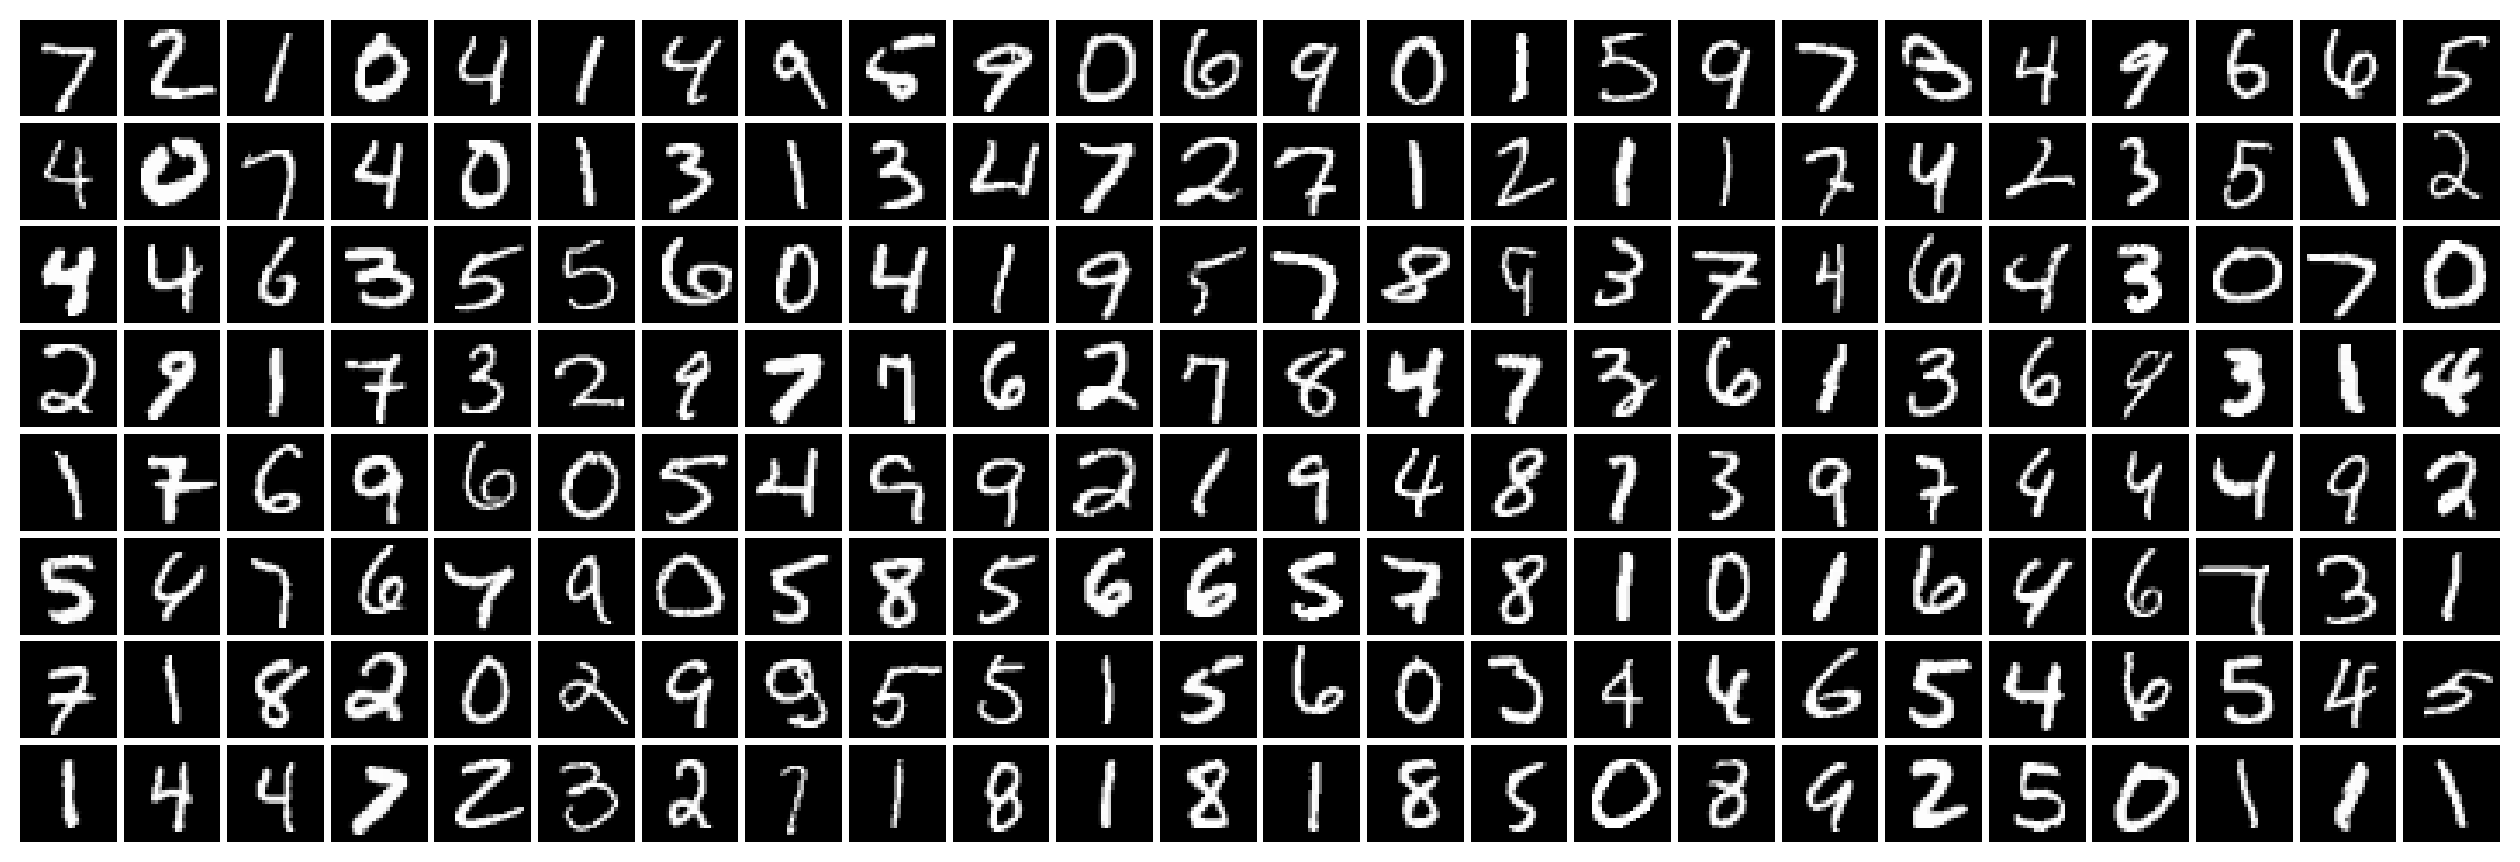

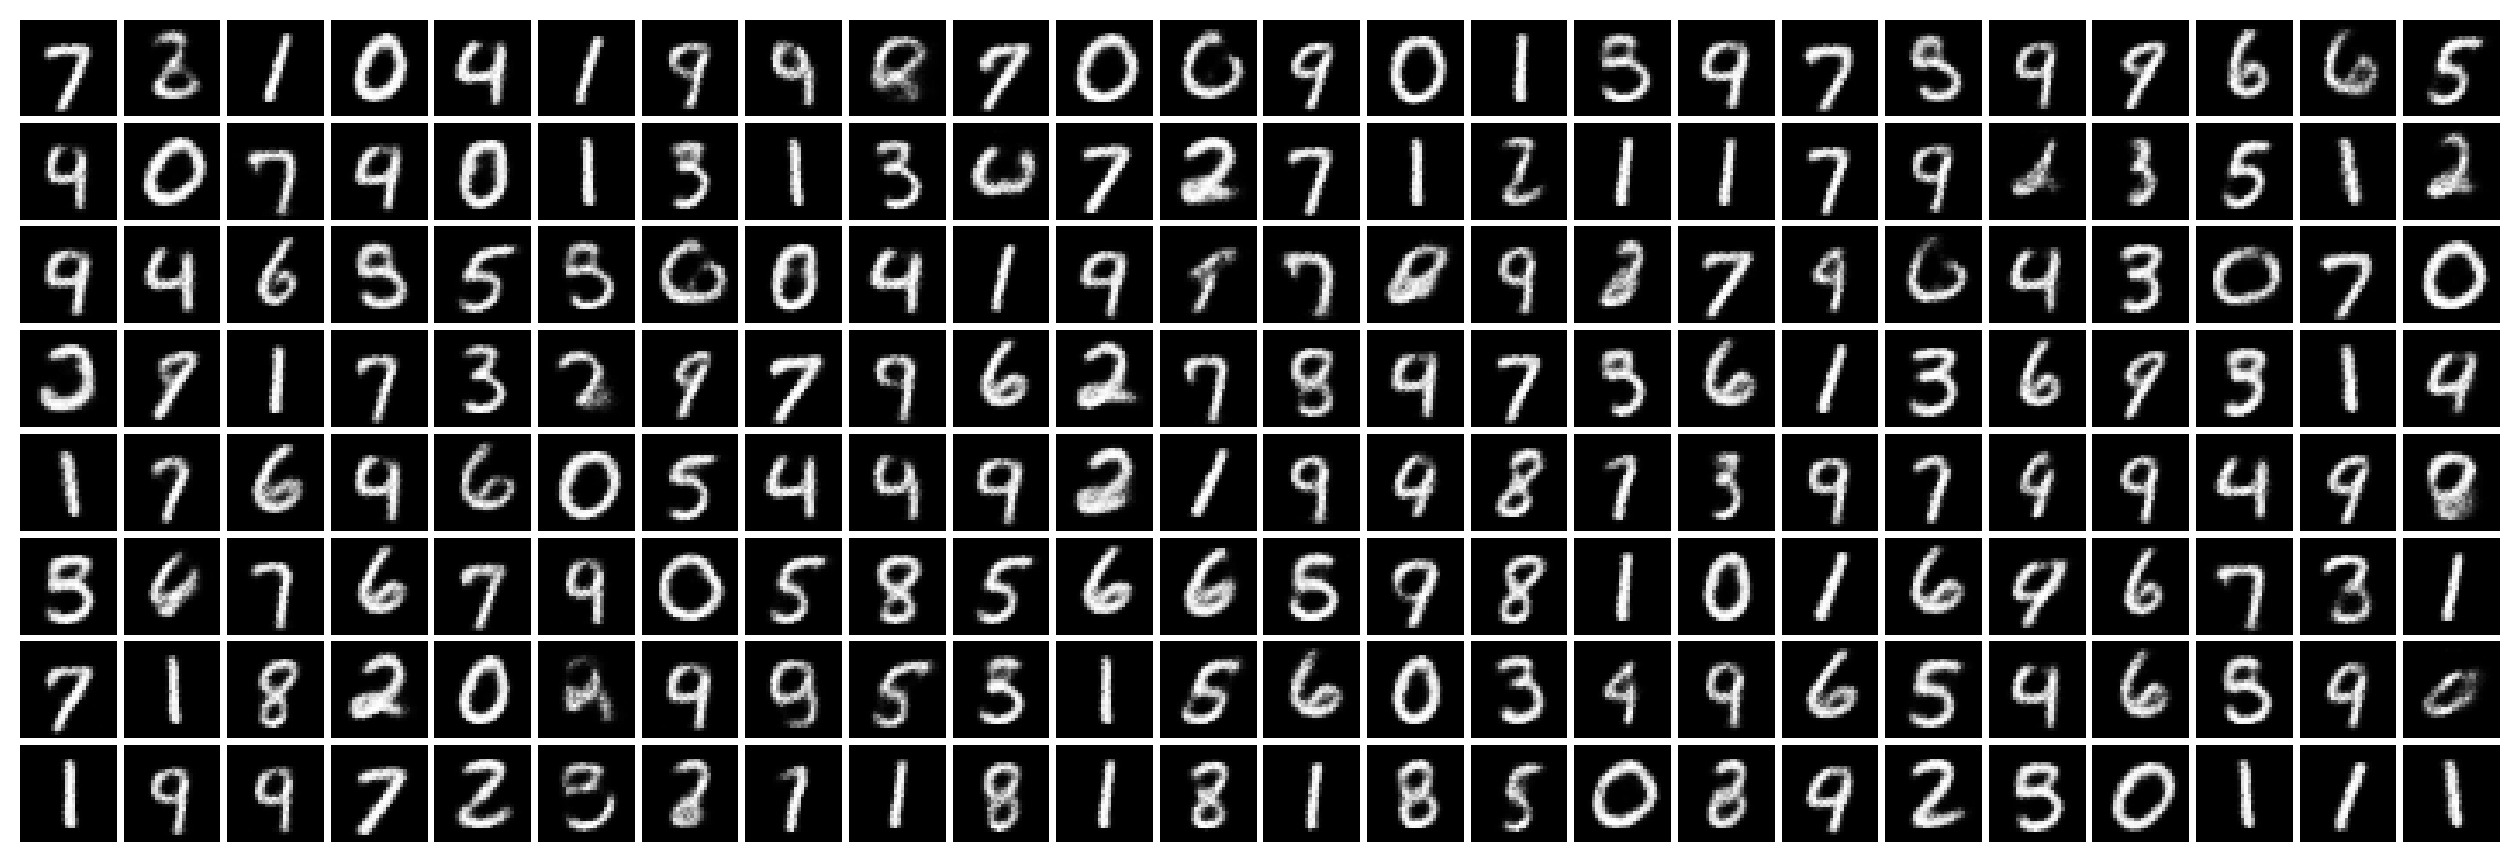

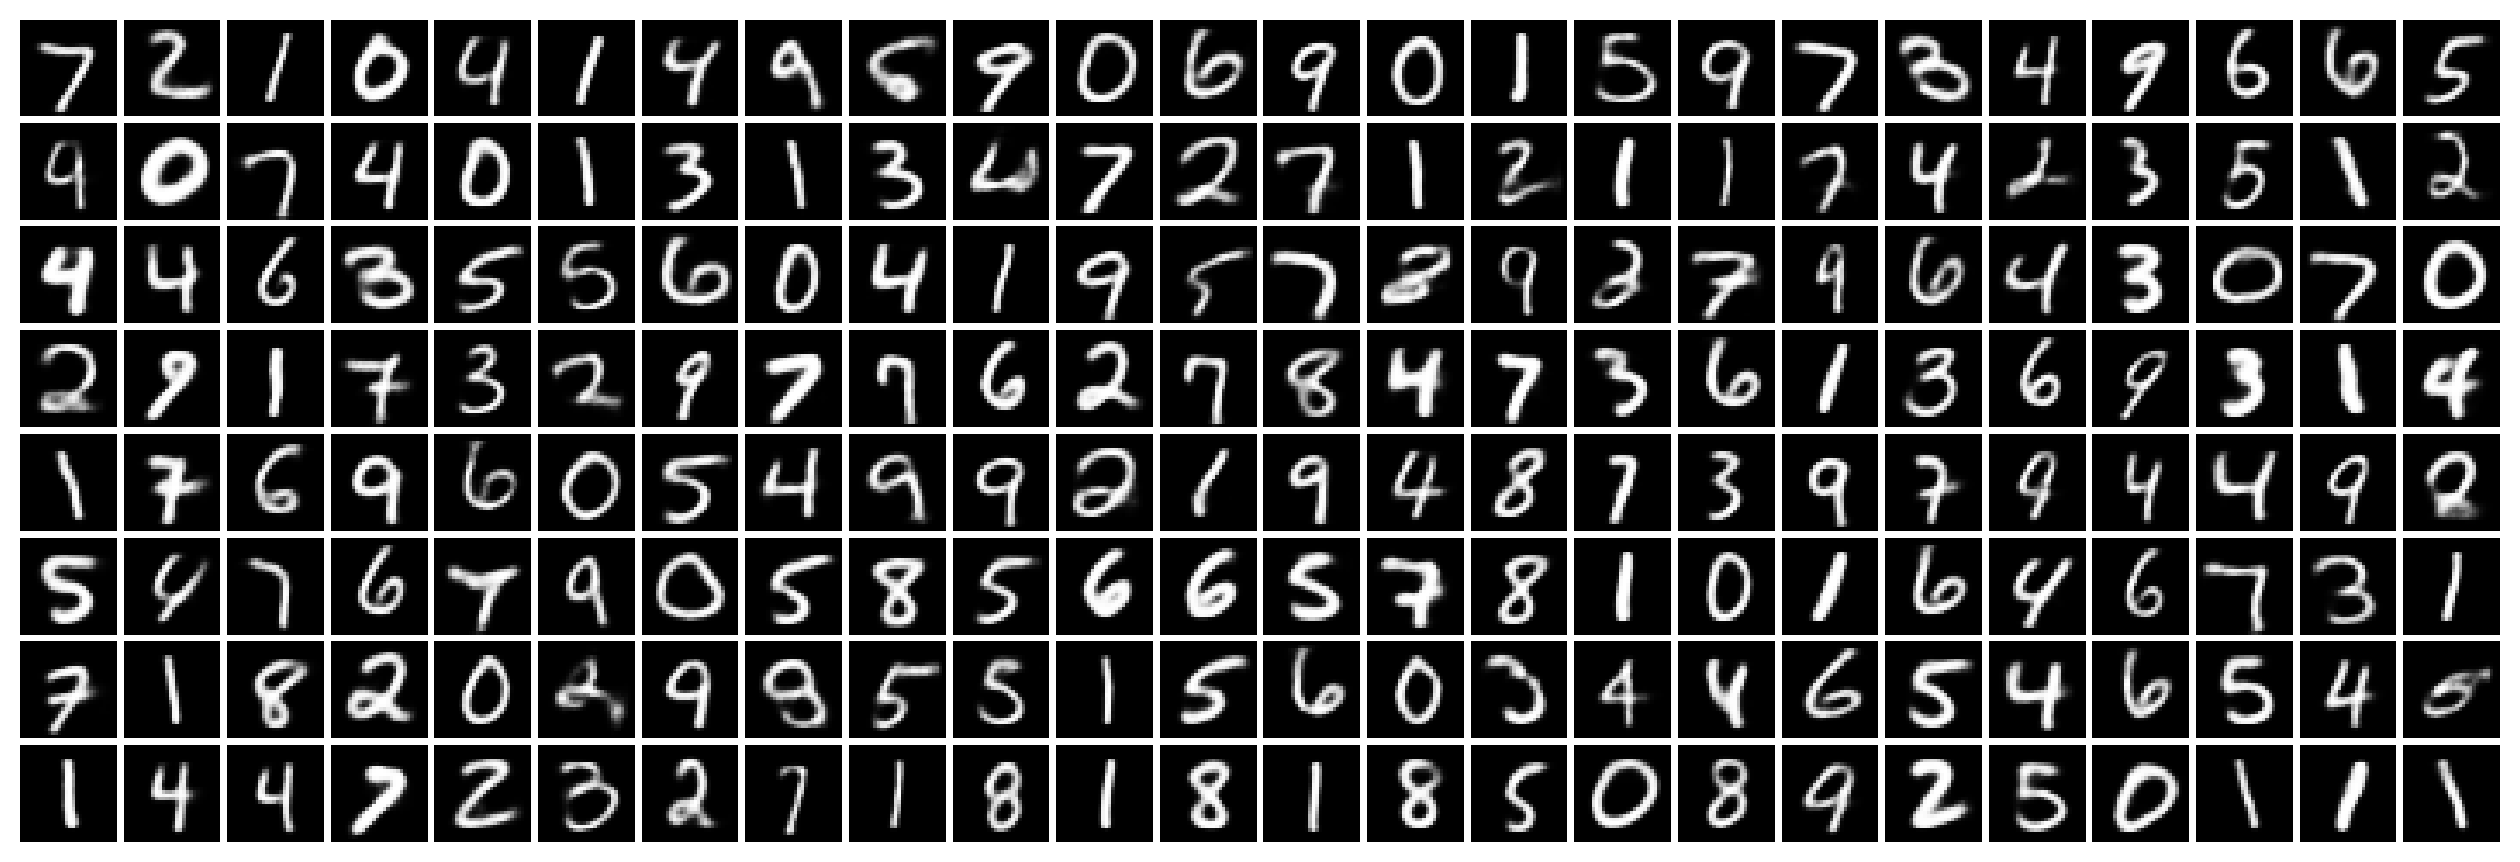

In [22]:
dbn = [
    RBM(VISIBLE_LAYER_SIZE, 256, sigmoid, sigmoid, RBM_LEARNING_RATE, 0.5, L2_PENALTY, init_method="Xavier"),
    RBM(256, 128, sigmoid, sigmoid, RBM_LEARNING_RATE, 0.5, L2_PENALTY, init_method="Xavier"),
    RBM(128, 64, sigmoid, sigmoid, RBM_LEARNING_RATE, 0.5, L2_PENALTY, init_method="Xavier"),
    RBM(64, 10, sigmoid, gaussian, RBM_LEARNING_RATE / 10.0, 0.5, L2_PENALTY, init_method="Xavier"),
]

ae = [
    Linear(VISIBLE_LAYER_SIZE, 256, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY, init_method="Xavier"),
    Sigmoid(),
    Linear(256, 128, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY, init_method="Xavier"),
    Sigmoid(),
    Linear(128, 64, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY, init_method="Xavier"),
    Sigmoid(),
    Linear(64, 10, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY, init_method="Xavier"),
    #
    Linear(10, 64, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY, init_method="Xavier"),
    Sigmoid(),
    Linear(64, 128, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY, init_method="Xavier"),
    Sigmoid(),
    Linear(128, 256, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY, init_method="Xavier"),
    Sigmoid(),
    Linear(256, VISIBLE_LAYER_SIZE, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY, init_method="Xavier"),
]

compare_results(
    ae,
    dbn,
    mnist_train_images,
    mnist_test_images,
    monitoring_set,
    BATCH_SIZE,
    EPOCHS_COUNT,
)

# Part 2. Visualization of MNIST digits with an autoencoder

In [23]:
def run_2d_ae_training(
    ae: Sequence[Layer],
    X_train: NDArray,
    X_valid: NDArray,
    batch_size: int,
    epochs_count: int,
):
    for epoch in range(epochs_count):
        print("Epoch {}:".format(epoch + 1), end="\t")

        start_time = time.time()
        train_ae(ae, X_train, batch_size)
        elapsed = time.time() - start_time

        xe = xentropy(X_valid, forward_pass(ae, X_valid, training=False))
        print("\telapsed: {0:>2.2f}s, cross-entropy: {1:>2.2f}".format(elapsed, xe))

    print("Training finished!")

In [24]:
def plot_2d_mnist_scatter(X: NDArray, y: NDArray):
    fig, plot = plt.subplots()
    fig.set_size_inches(16, 16)
    plt.prism()

    for i in range(10):
        digit_indeces = y == i
        dim1 = X[digit_indeces, 0]
        dim2 = X[digit_indeces, 1]
        plot.scatter(dim1, dim2, label=str(i))

    plot.set_xticks(())
    plot.set_yticks(())

    plt.tight_layout()
    plt.legend()
    plt.show()

In [25]:
from IPython.core.display import HTML


def compare_2d_visualizations(
    ae: Sequence[Layer],
    dbn: Sequence[RBM],
    X_train: NDArray,
    X_valid: NDArray,
    y_valid: NDArray,
    monitoring_set: NDArray,
    batch_size: int,
    epochs_count: int,
):
    for layer in ae:
        layer.reset()

    display(HTML("<h3>DBN training</h3>"))
    train_dbn(dbn, X_train, monitoring_set, batch_size, epochs_count)

    initialize_ae(ae, dbn)
    dbn_rec_cost = xentropy(X_valid, forward_pass(ae, X_valid, training=False))

    _ = forward_pass(ae, X_valid, training=False)
    dbn_codes = ae[6].y

    display(HTML("<h3>Finetuning pretrained AE</h3>"))

    print("Reconstruction cost before finetuning: {0:>2.2f}\n".format(dbn_rec_cost))
    run_2d_ae_training(ae, X_train, X_valid, batch_size, epochs_count)

    _ = forward_pass(ae, X_valid, training=False)
    ae_codes = ae[6].y

    display(HTML("<h3>2D codes from the pretrained AE</h3>"))
    plot_2d_mnist_scatter(dbn_codes, y_valid)

    display(HTML("<h3>2D codes from the finetuned AE</h3>"))
    plot_2d_mnist_scatter(ae_codes, y_valid)

In [26]:
DATASET_SIZE = 60_000  # 60000 for whole dataset
DIGIT_SIZE = 28

##### Train set #####

mnist_train_images = mnist.train_images().astype(np.float32) / 255.0
mnist_train_images = np.random.permutation(mnist_train_images)

mnist_train_images = mnist_train_images[:DATASET_SIZE]
mnist_train_images = mnist_train_images.reshape(DATASET_SIZE, DIGIT_SIZE * DIGIT_SIZE)
# mnist_train_images = append_ones(mnist_train_images)

monitoring_set_indeces = np.random.choice(mnist_train_images.shape[0], 512, replace=False)
monitoring_set = mnist_train_images[monitoring_set_indeces]

##### Test set #####

mnist_test_images = mnist.test_images().astype(np.float32) / 255.0
mnist_test_images = mnist_test_images.reshape(-1, DIGIT_SIZE * DIGIT_SIZE)
# mnist_test_images = append_ones(mnist_test_images)
mnist_test_labels = mnist.test_labels()

In [27]:
VISIBLE_LAYER_SIZE = DIGIT_SIZE*DIGIT_SIZE

BATCH_SIZE = 128
EPOCHS_COUNT = 50

RBM_LEARNING_RATE = 0.1
AE_LEARNING_RATE = 0.01
AE_MOMENTUM = 0.8
L2_PENALTY = 0.0002

###  Autoencoder network for 2D visualization

Define the autoencoder network for MNIST digits. Use the network structure from the previous part, but change the size of the coding layer to 2 neurons.


Learning layer 0
Epoch 1:	########################################	elapsed: 1.97s, reconstruction error: 14.74
Epoch 2:	########################################	elapsed: 1.81s, reconstruction error: 12.07
Epoch 3:	########################################	elapsed: 2.08s, reconstruction error: 10.74
Epoch 4:	########################################	elapsed: 1.99s, reconstruction error: 10.27
Epoch 5:	########################################	elapsed: 2.46s, reconstruction error: 9.53
Epoch 6:	########################################	elapsed: 2.08s, reconstruction error: 9.84
Epoch 7:	########################################	elapsed: 1.82s, reconstruction error: 9.32
Epoch 8:	########################################	elapsed: 2.03s, reconstruction error: 9.15
Epoch 9:	########################################	elapsed: 2.19s, reconstruction error: 9.00
Epoch 10:	########################################	elapsed: 4.20s, reconstruction error: 8.97
Epoch 11:	#####################################

Reconstruction cost before finetuning: 249.63

Epoch 1:	########################################	elapsed: 2.02s, cross-entropy: 155.73
Epoch 2:	########################################	elapsed: 1.97s, cross-entropy: 149.29
Epoch 3:	########################################	elapsed: 1.95s, cross-entropy: 146.01
Epoch 4:	########################################	elapsed: 1.87s, cross-entropy: 143.74
Epoch 5:	########################################	elapsed: 1.83s, cross-entropy: 142.07
Epoch 6:	########################################	elapsed: 1.83s, cross-entropy: 140.84
Epoch 7:	########################################	elapsed: 1.81s, cross-entropy: 139.84
Epoch 8:	########################################	elapsed: 1.79s, cross-entropy: 139.11
Epoch 9:	########################################	elapsed: 1.89s, cross-entropy: 138.25
Epoch 10:	########################################	elapsed: 2.08s, cross-entropy: 137.65
Epoch 11:	########################################	elapsed: 1.82s, cross

/tmp/ipykernel_59670/4227905998.py:9: RuntimeWarning: overflow encountered in exp
  self.y = 1.0 / (1.0 + np.exp(-x))


###############	elapsed: 3.21s, cross-entropy: 131.35
Epoch 37:	########################################	elapsed: 3.17s, cross-entropy: 131.27
Epoch 38:	########################################	elapsed: 3.22s, cross-entropy: 131.02
Epoch 39:	########################################	elapsed: 2.47s, cross-entropy: 131.08
Epoch 40:	########################################	elapsed: 3.15s, cross-entropy: 130.81
Epoch 41:	########################################	elapsed: 2.48s, cross-entropy: 130.93
Epoch 42:	########################################	elapsed: 6.08s, cross-entropy: 130.87
Epoch 43:	########################################	elapsed: 2.63s, cross-entropy: 131.84
Epoch 44:	########################################	elapsed: 3.28s, cross-entropy: 130.68
Epoch 45:	########################################	elapsed: 3.16s, cross-entropy: 130.37
Epoch 46:	########################################	elapsed: 2.96s, cross-entropy: 130.52
Epoch 47:	########################################	elaps

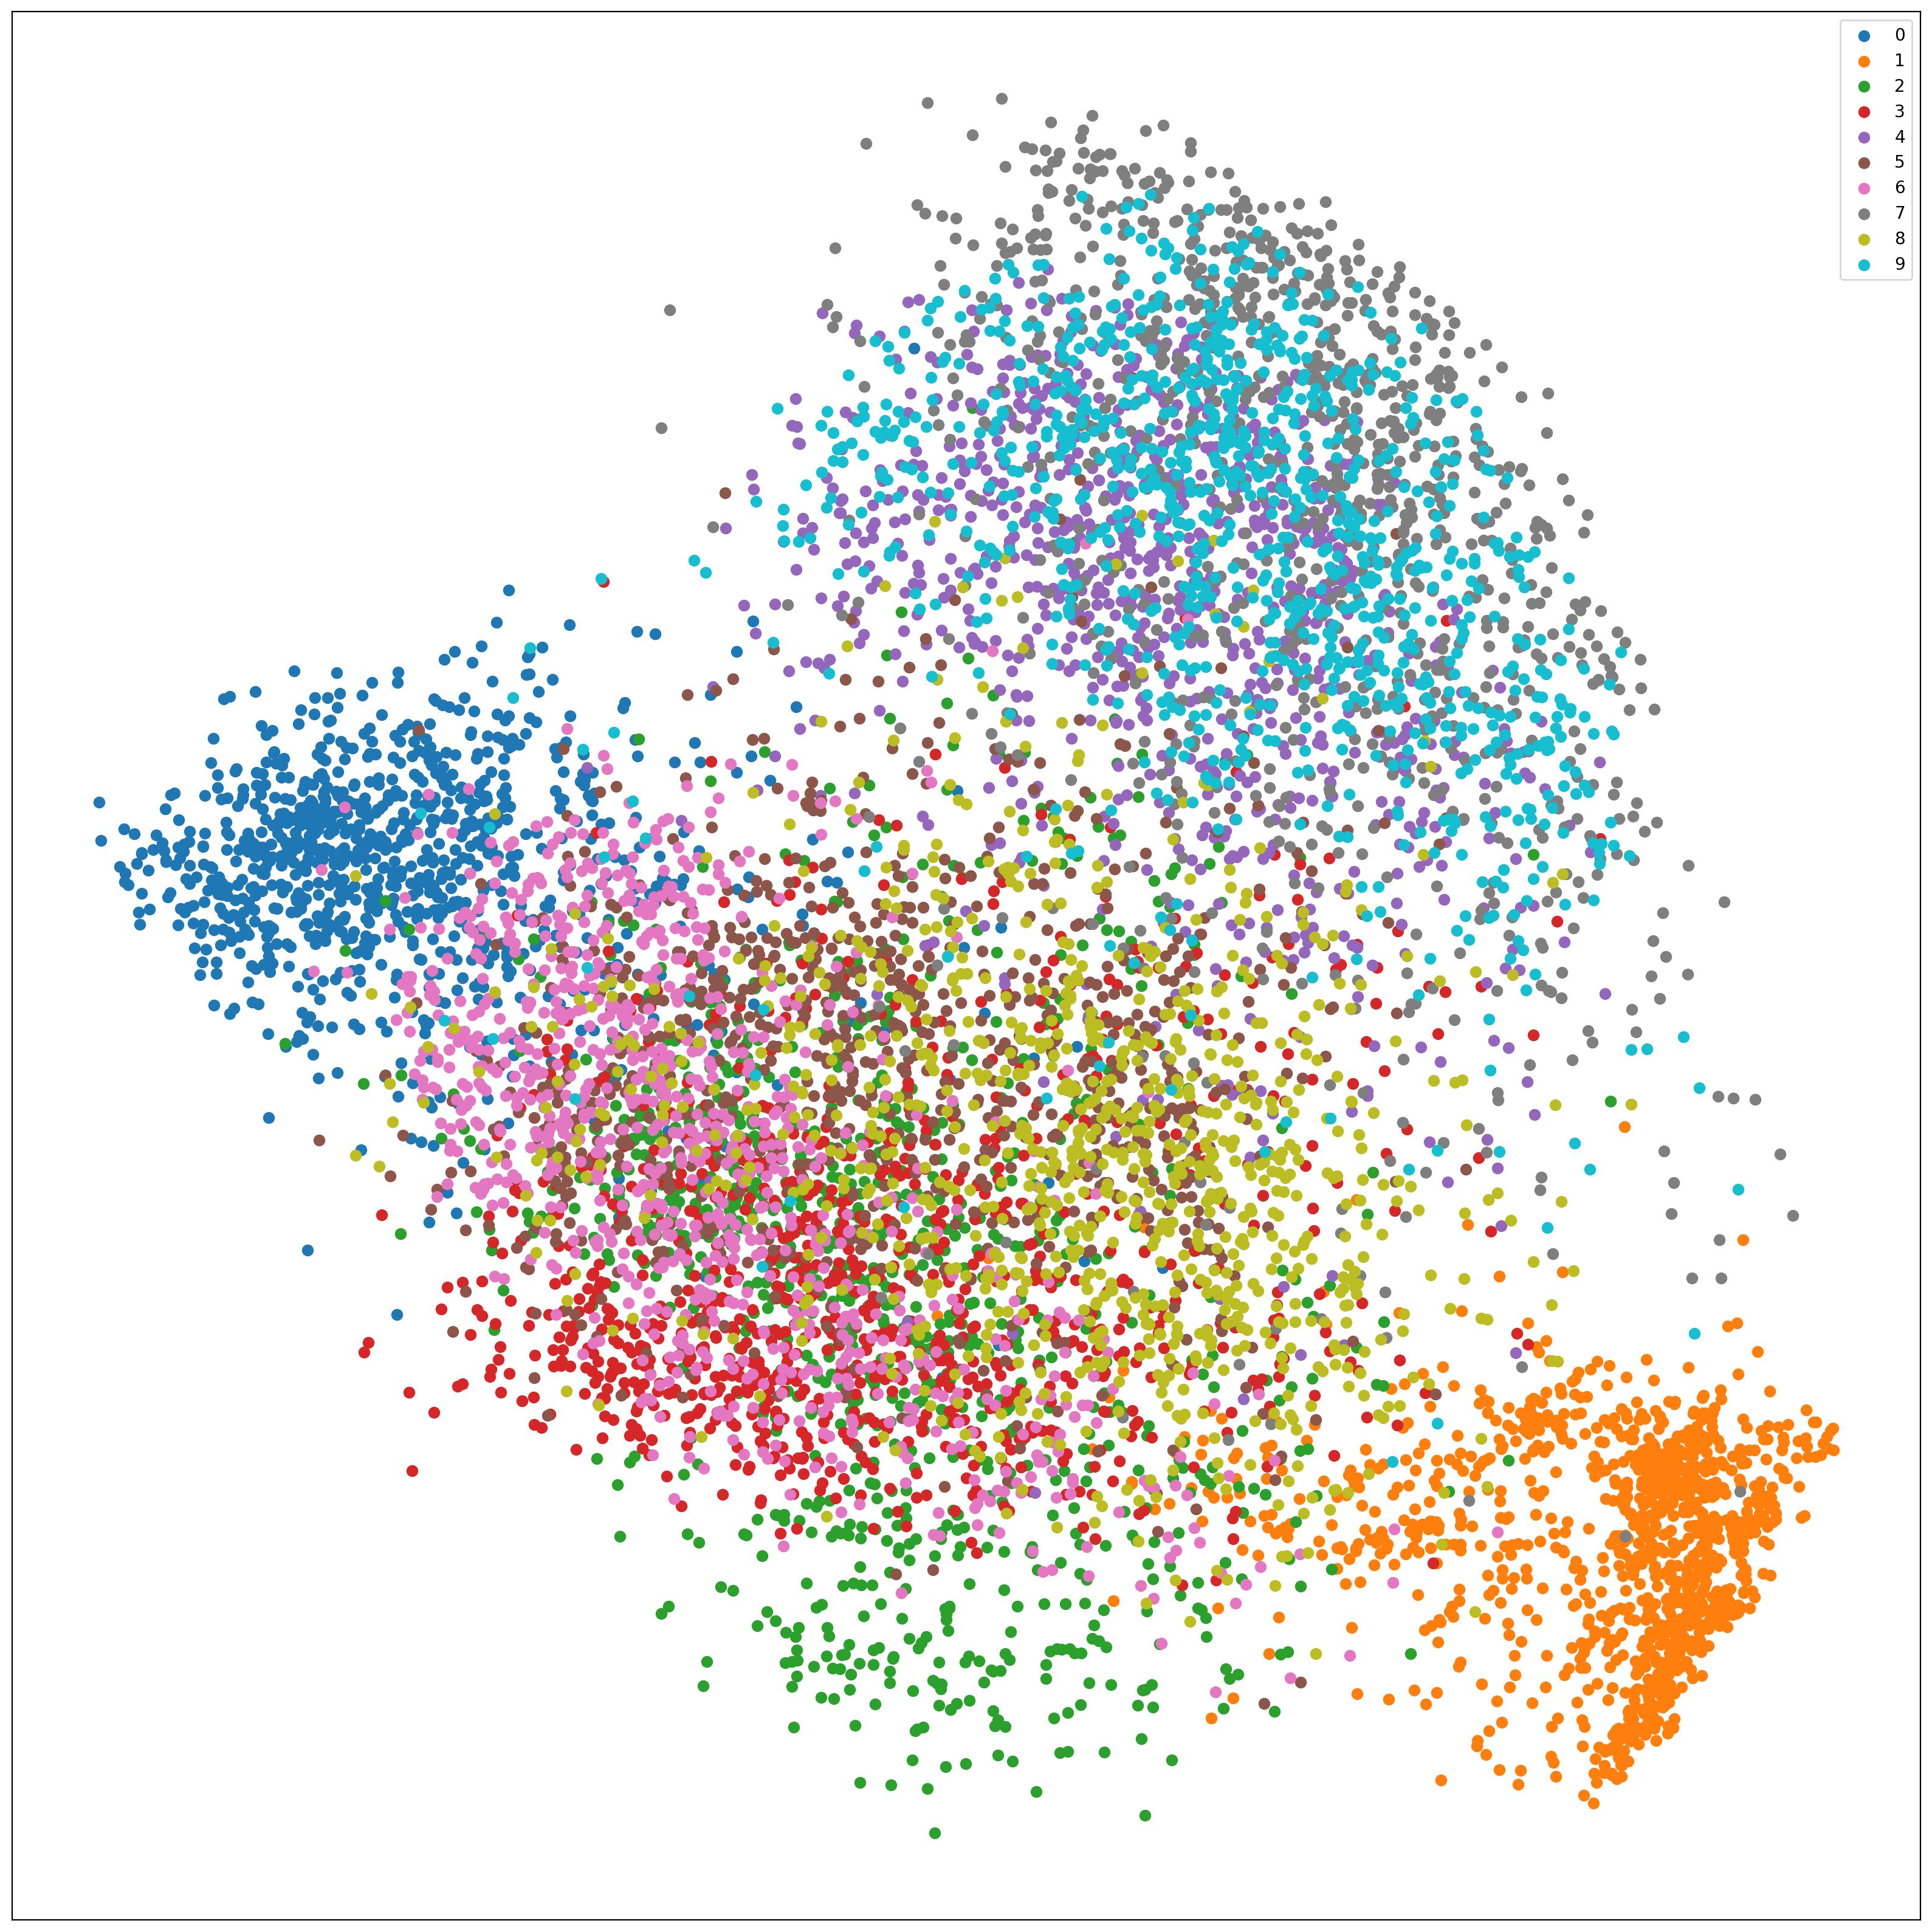

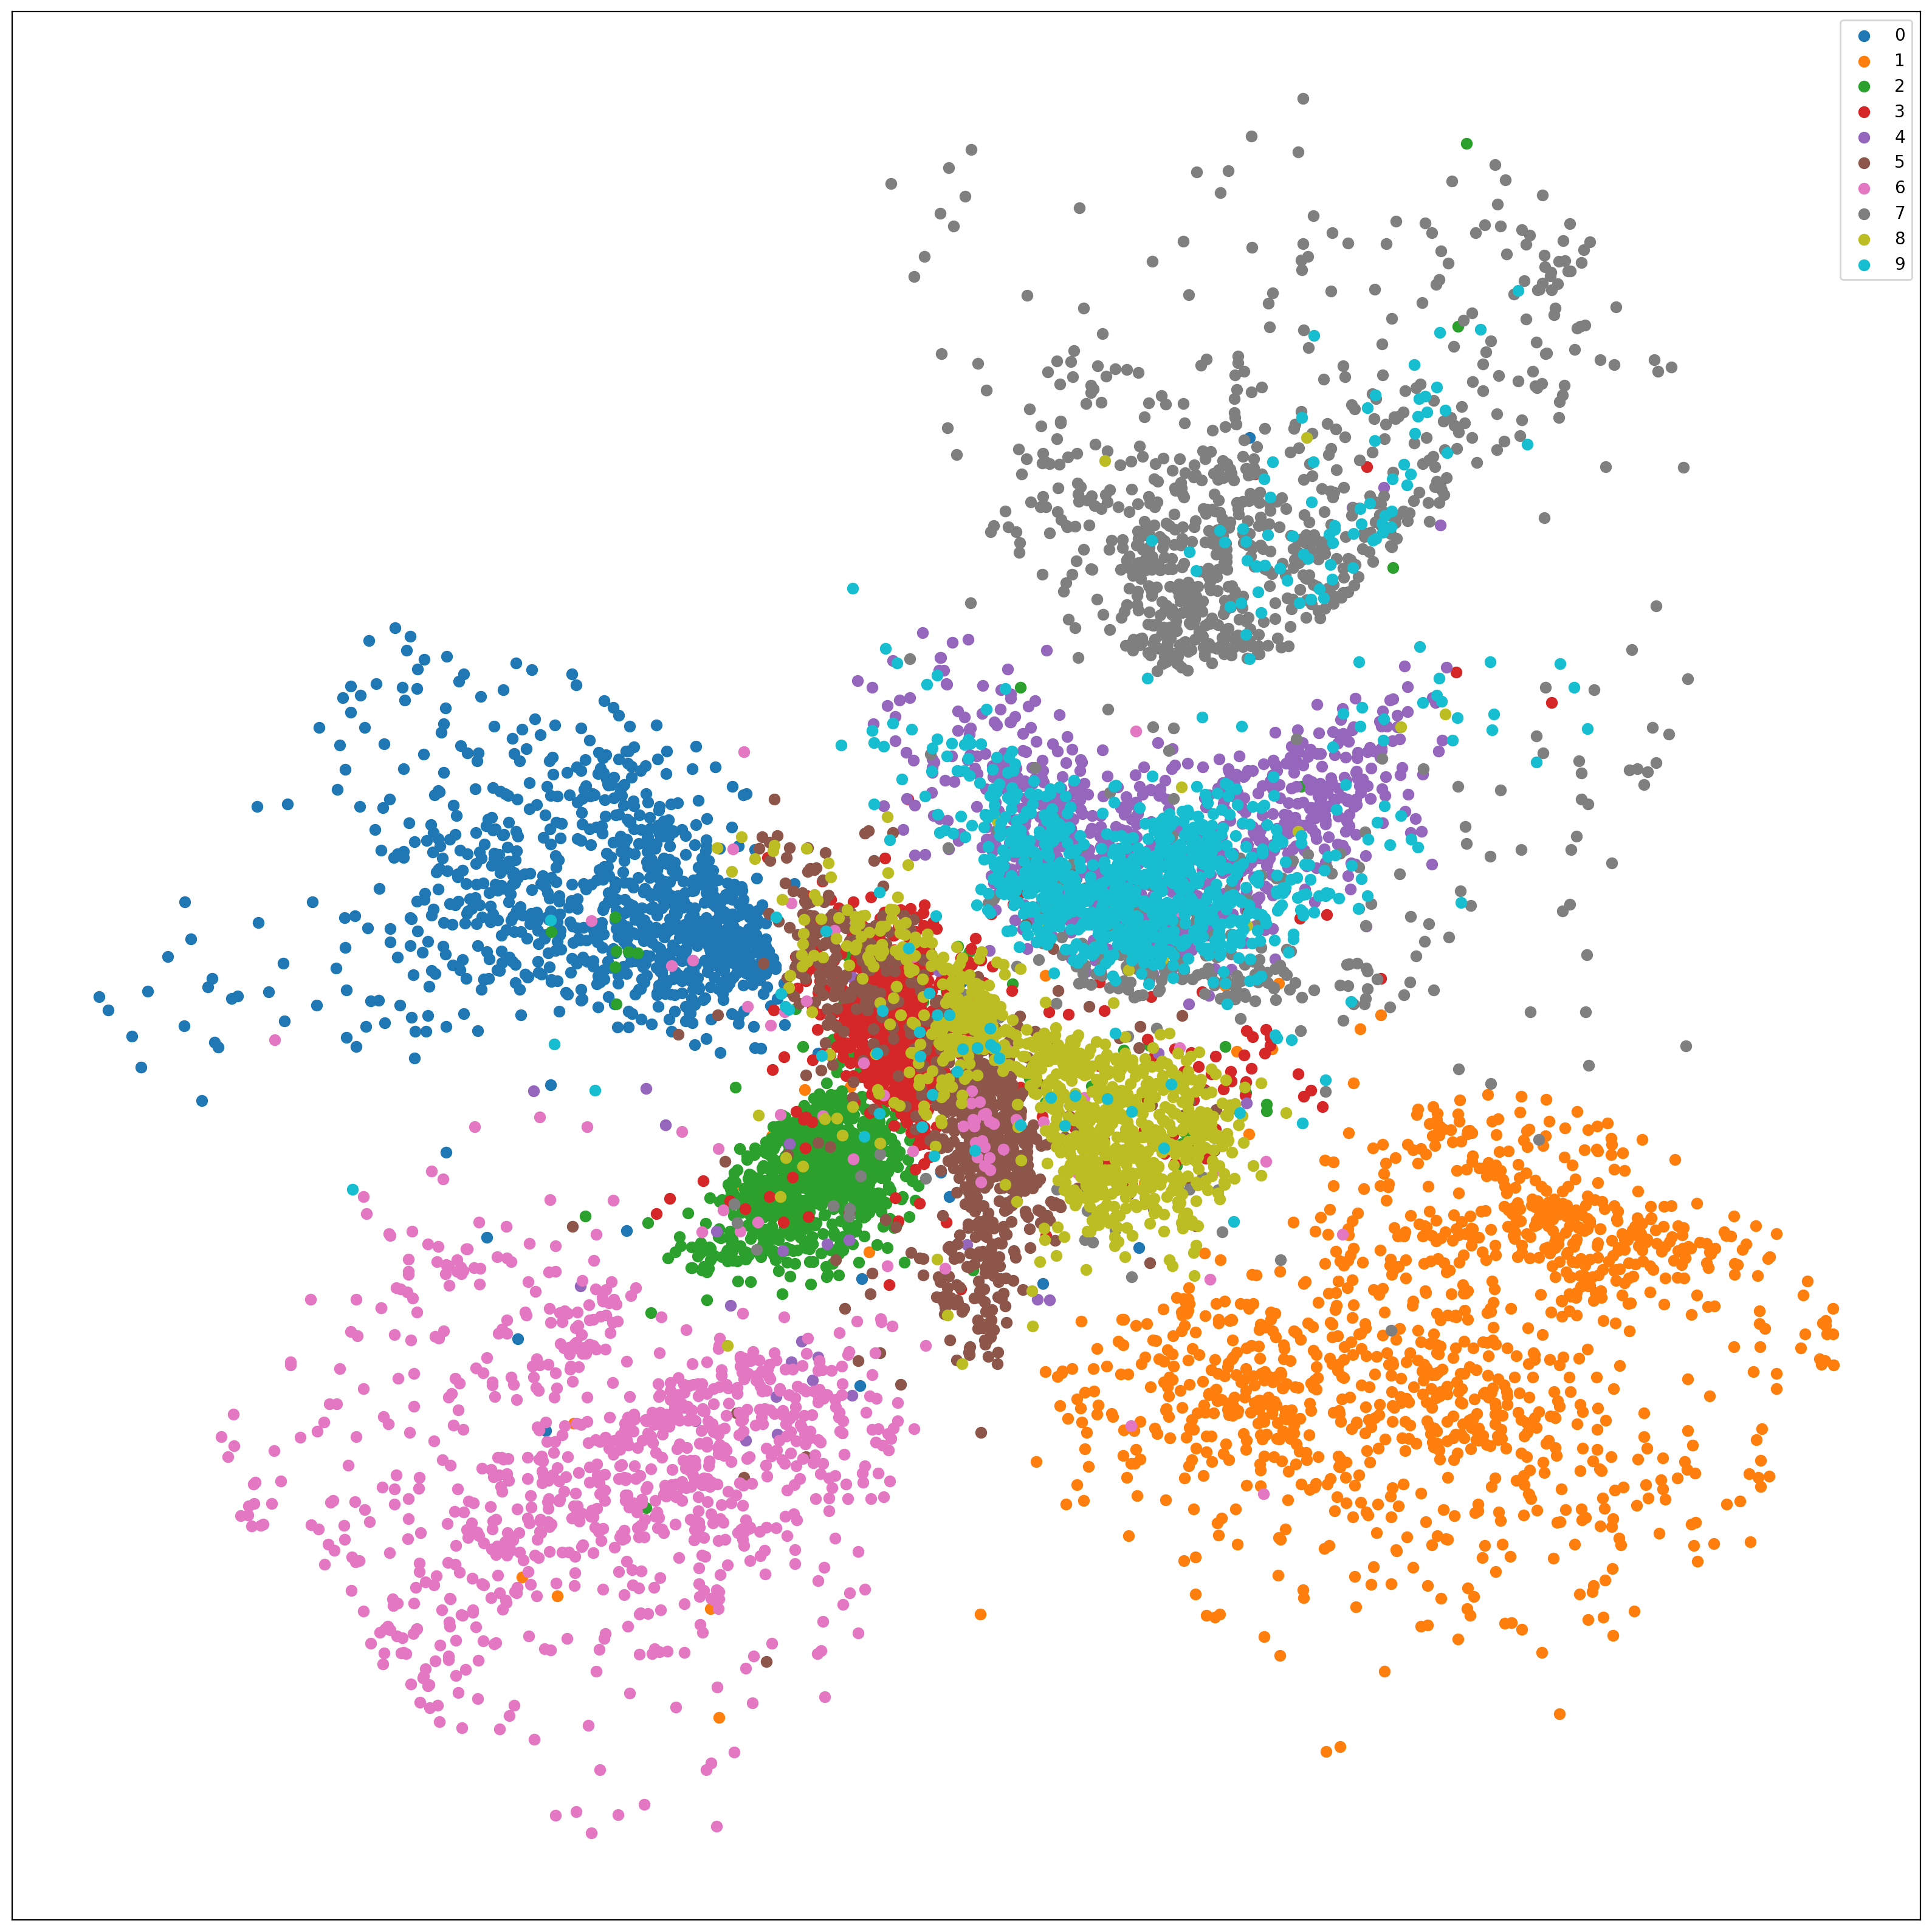

In [28]:
dbn = [
    RBM(VISIBLE_LAYER_SIZE, 256, sigmoid, sigmoid, RBM_LEARNING_RATE, 0.5, L2_PENALTY, init_method="Xavier"),
    RBM(256, 128, sigmoid, sigmoid, RBM_LEARNING_RATE, 0.5, L2_PENALTY, init_method="Xavier"),
    RBM(128, 64, sigmoid, sigmoid, RBM_LEARNING_RATE, 0.5, L2_PENALTY, init_method="Xavier"),
    RBM(64, 2, sigmoid, gaussian, RBM_LEARNING_RATE / 10.0, 0.5, L2_PENALTY, init_method="Xavier"),
]

ae = [
    Linear(VISIBLE_LAYER_SIZE, 256, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY, init_method="Xavier"),
    Sigmoid(),
    Linear(256, 128, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY, init_method="Xavier"),
    Sigmoid(),
    Linear(128, 64, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY, init_method="Xavier"),
    Sigmoid(),
    Linear(64, 2, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY, init_method="Xavier"),
    #
    Linear(2, 64, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY, init_method="Xavier"),
    Sigmoid(),
    Linear(64, 128, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY, init_method="Xavier"),
    Sigmoid(),
    Linear(128, 256, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY, init_method="Xavier"),
    Sigmoid(),
    Linear(256, VISIBLE_LAYER_SIZE, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY, init_method="Xavier"),
]

compare_2d_visualizations(
    ae,
    dbn,
    mnist_train_images,
    mnist_test_images,
    mnist_test_labels,
    monitoring_set,
    BATCH_SIZE,
    EPOCHS_COUNT,
)